In [1]:
import networkx as nx
import random
import time
import matplotlib.pyplot as plt
from community import community_louvain  # Louvain algorithm
from networkx.algorithms.community import girvan_newman
import numpy as np
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import os
# Load your graph (replace with your dataset)
# G = nx.karate_club_graph()  # Example dataset


In [2]:
file_path = Path(os.path.join('..', 'data', 'ca-GrQc.txt', 'CA-GrQc.txt'))

df_graph = pd.read_csv(filepath_or_buffer=file_path, header=None, names=['from', 'to'], sep='\t', skiprows=4)
display(df_graph.head())

G = nx.from_pandas_edgelist(df=df_graph, source='from', target='to')

print(f'Number of Edges: {G.size()}')
print(f'Number of Nodes: {G.order()}')


,from,to
0,3466,937
1,3466,5233
2,3466,8579
3,3466,10310
4,3466,15931


Number of Edges: 14496
Number of Nodes: 5242


In [8]:
def sample_subgraphs(G, orders, num_samples):
    """Samples subgraphs of different orders."""
    subgraphs = {}
    nodes = list(G.nodes())
    for order in orders:
        subgraphs[order] = [
            G.subgraph(random.sample(nodes, order)).copy() for _ in range(num_samples)
        ]
    return subgraphs

# Define subgraph orders and the number of samples per order
graph_order = G.number_of_nodes()
orders = [int(graph_order * frac) for frac in np.linspace(0.1, 0.9, 10)]  # 10%-100%
print(orders)
num_samples = 5  # Number of subgraphs per order

# Sample subgraphs
subgraphs = sample_subgraphs(G, orders, num_samples)


[524, 990, 1456, 1922, 2388, 2853, 3319, 3785, 4251, 4717]


In [4]:
def time_girvan_newman(G, max_levels=3):
    """Time the Girvan-Newman algorithm."""
    start_time = time.time()
    comp = girvan_newman(G)
    for _ in range(max_levels):  # Limit levels to prevent long runtimes
        next(comp)
    return time.time() - start_time

def time_louvain(G):
    """Time the Louvain algorithm."""
    start_time = time.time()
    community_louvain.best_partition(G)
    return time.time() - start_time

# Measure runtimes
results = {"order": [], "algorithm": [], "runtime": []}
for order in tqdm(orders, desc="Processing subgraphs"):
    for G_sub in subgraphs[order]:
        # Girvan-Newman
        gn_time = time_girvan_newman(G_sub, max_levels=3)
        results["order"].append(order)
        results["algorithm"].append("Girvan-Newman")
        results["runtime"].append(gn_time)

        # Louvain
        louvain_time = time_louvain(G_sub)
        results["order"].append(order)
        results["algorithm"].append("Louvain")
        results["runtime"].append(louvain_time)


Processing subgraphs:   0%|          | 0/10 [00:00<?, ?it/s]

Processing subgraphs: 100%|██████████| 10/10 [00:43<00:00,  4.33s/it]


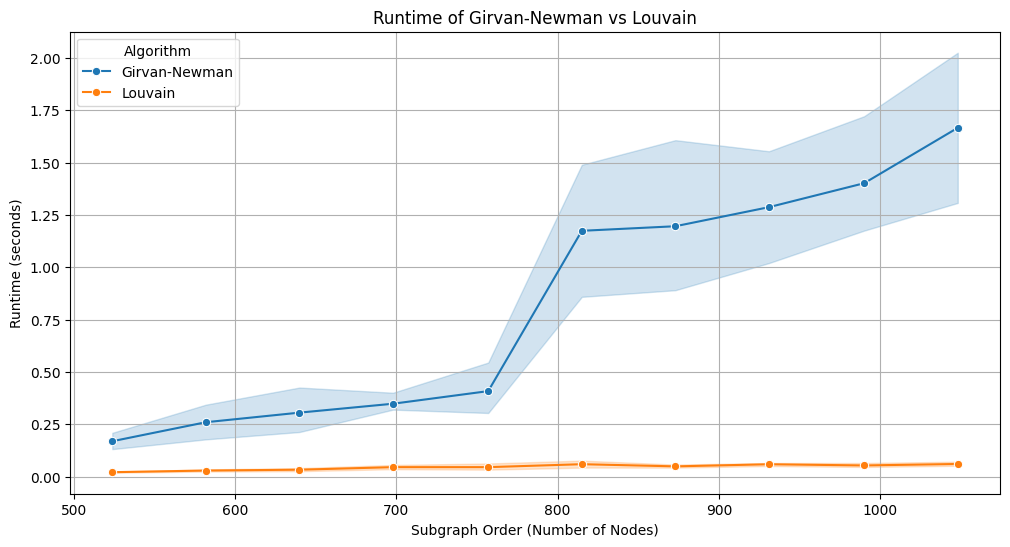

In [5]:
import pandas as pd
import seaborn as sns

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Plot the runtimes
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="order", y="runtime", hue="algorithm", marker="o")
plt.title("Runtime of Girvan-Newman vs Louvain")
plt.xlabel("Subgraph Order (Number of Nodes)")
plt.ylabel("Runtime (seconds)")
plt.legend(title="Algorithm")
plt.grid(True)
plt.show()
